# Fake News Detection

## Imports and Data Set Up

In [1]:
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import time
import string
import nltk
from nltk.corpus import stopwords 

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix

In [2]:
## Data sets from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
df_fake = pd.read_csv('data/Fake.csv')
df_real = pd.read_csv('data/True.csv')

df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
# Function for 'cleaning' text. Returns the text after removing punctuation and common words in the english language.
stops = stopwords.words('english')
def clean_text(txt):
    s = txt.translate(str.maketrans('', '', string.punctuation)).lower()
    return ' '.join([word for word in s.split() if word not in (stops)])

In [4]:
## Label article types
df_fake['label'] = 'FAKE'
df_real['label'] = 'REAL'

df = shuffle(pd.concat([df_fake, df_real])) # combine and shuffle data
df.drop(['date'],axis=1,inplace=True) # drop not needed for current analysis
df = df.dropna(axis=0).reset_index(drop=True) # remove rows with missing information

# clean the text and title columns
for col in ['title', 'text']: 
    df[col] = df[col].apply(lambda s: clean_text(s))

df.head()

,title,text,subject,label
0,laura ingraham’s brilliant idea shake liberal ...,laura ingraham sean hannity hysterical intervi...,politics,FAKE
1,hillary “berned”…obama tells donors back hilla...,hillary failing miserably young voters wildest...,politics,FAKE
2,exclusive china curbs tourism north korea ahea...,beijingseoul reuters chinese tour operators ba...,worldnews,REAL
3,world freaking hell trump watching ‘finding dory’,alleged president donald trump created worldwi...,News,FAKE
4,bernie sanders you’re white don’t know it’s li...,bernie sanders focused pandering blacks trashi...,politics,FAKE


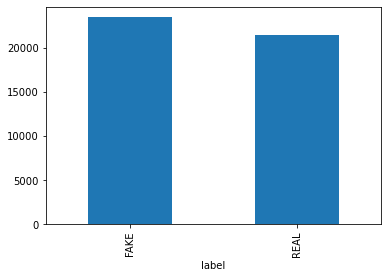

In [5]:
# breakdown by article label
df.groupby(['label'])['text'].count()
df.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


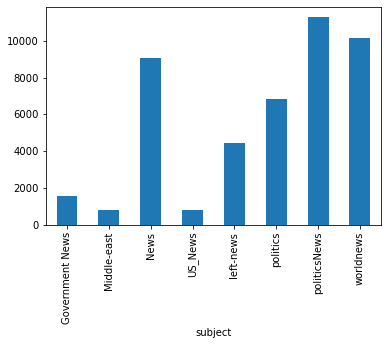

In [8]:
# breakdown by article subject
print(df.groupby(['subject'])['text'].count())
df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

In [9]:
labels = df['label']

In [10]:
# Return subset of data, with specified amount of articles from each group
def takeSample(group_size):
    r = df[df['label'] == 'REAL']
    realSample = r.sample(n=group_size)
    
    f = df[df['label'] == 'FAKE']
    fakeSample = f.sample(n=group_size)
    
    return shuffle(pd.concat([realSample, fakeSample])).reset_index(drop=True)

# Proof of Model Concept

In [14]:
vectorizer = TfidfVectorizer()

splits = 2
kf = KFold(n_splits=splits)

df_sample = takeSample(6000)
labels = df_sample['label']

### Text Model

[[2949   60]
 [  39 2952]]
[[2927   64]
 [  30 2979]]
Time to run: 144.48997282981873


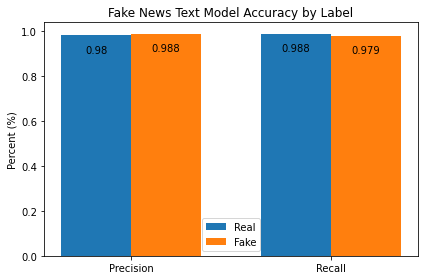

In [38]:
text_start = time.time() ## start timer
text_features = vectorizer.fit_transform(df_sample['text'])

precision_real, recall_real  = 0, 0 
precision_fake, recall_fake = 0, 0

for train, test in kf.split(text_features):
    model = SVC()
    model.fit(text_features[train], labels.iloc[train]) # trains the data   
    predicts =  model.predict(text_features[test])  # tests and predicts        
    
    print(metrics.confusion_matrix(labels[test].tolist(), predicts))

    report = classification_report(labels[test], predicts, output_dict=True)
    precision_real += report.get('REAL').get('precision')
    recall_real += report.get('REAL').get('recall')
    precision_fake += report.get('FAKE').get('precision')
    recall_fake += report.get('FAKE').get('recall')
    
# calculate avg precision and recall from the n random samples
precision_real /= splits
precision_fake /= splits
recall_real /= splits
recall_fake /= splits

text_end = time.time()
print("Time to run:", text_end - text_start)

# Avg Precision-Accuracy graph ----------------------------------------------------------------------
labels = ['Precision', 'Recall']
decimal_places = 3
real = (round(precision_real, decimal_places), round(recall_real, decimal_places))
fake = (round(precision_fake, decimal_places), round(recall_fake, decimal_places))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, fake, width, label='Fake')

ax.set_ylabel('Percent (%)')
ax.set_title('Fake News Text Model Accuracy by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

### Title Model Concept

As seen above, the text based prediction model is quite time intensive. This model is checking whether a model using only the title of the article has a sufficient accuracy.

[[2186  890]
 [2075  849]]
[[1836 1328]
 [1652 1184]]
Time to run: 13.254244089126587


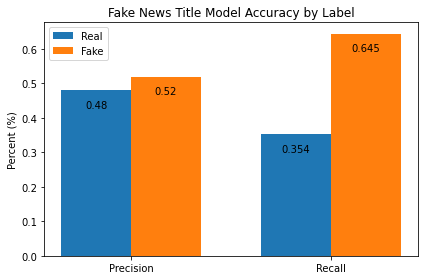

In [39]:
text_start = time.time() ## start timer

title_features = vectorizer.fit_transform(df_sample['title'])
labels = df['label']

precision_real, recall_real  = 0, 0 
precision_fake, recall_fake = 0, 0

for train, test in kf.split(title_features):
    model = SVC()
    model.fit(title_features[train], labels.iloc[train]) # trains the data  
    predicts =  model.predict(title_features[test])  # tests and predicts        
    
    print(metrics.confusion_matrix(labels[test].tolist(), predicts))

    report = classification_report(labels[test], predicts, output_dict=True)
    precision_real += report.get('REAL').get('precision')
    recall_real += report.get('REAL').get('recall')
    precision_fake += report.get('FAKE').get('precision')
    recall_fake += report.get('FAKE').get('recall')
    
# calculate avg precision and recall from the n random samples
precision_real /= splits
precision_fake /= splits
recall_real /= splits
recall_fake /= splits

text_end = time.time()
print("Time to run:", text_end - text_start)

# Avg Precision-Accuracy graph ----------------------------------------------------------------------
labels = ['Precision', 'Recall']
decimal_places = 3
real = (round(precision_real, decimal_places), round(recall_real, decimal_places))
fake = (round(precision_fake, decimal_places), round(recall_fake, decimal_places))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, fake, width, label='Fake')

ax.set_ylabel('Percent (%)')
ax.set_title('Fake News Title Model Accuracy by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

**After testing both of the models, we find the accuracy of the text based model to be sufficient for our intended purposes.** While the second title-based model has a faster initial set up period, the accuracy (with regards to both precision and recall) is low for both the real and fake articles tested.

# Creating Models

In [19]:
df_final = takeSample(8000)
final_labels = df_final['label']

In [ ]:
def train_text_model():
    model = SVC(probability=True)
    model.fit(vectorizer.fit_transform(df_final['text']), df_final['label'])
    return model

text_model = train_text_model()

print("Model based on article text created.")

# Imports Required for Basic Web Scraping

This project utilizes the BeautifulSoup package for parsing webpages to extract articles' titles and contents if possible.

In [ ]:
from bs4 import BeautifulSoup
import urllib.request

# Test Article by Text

In [ ]:
# TEST ARTICLES TO USE
# REALS: 
# https://www.cnn.com/2020/08/12/politics/kamala-harris-pronunciation/index.html
# WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. “We need to do DACA clean,” she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid.
# FAKES: 
# On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me,  the former sheriff tweeted.  I will continue to poke them in the eye with a sharp stick and bitch slap these scum bags til they get it. I have been attacked by better people than them #MAGA I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me. I will continue to poke them in the eye with a sharp stick and bitch slap these scum bags til they get it. I have been attacked by better people than them #MAGA pic.twitter.com/XtZW5PdU2b  David A. Clarke, Jr. (@SheriffClarke) December 30, 2017He didn t stop there.BREAKING NEWS! When LYING LIB MEDIA makes up FAKE NEWS to smear me, the ANTIDOTE is go right at them. Punch them in the nose & MAKE THEM TASTE THEIR OWN BLOOD. Nothing gets a bully like LYING LIB MEDIA S attention better than to give them a taste of their own blood #neverbackdown pic.twitter.com/T2NY2psHCR  David A. Clarke, Jr. (@SheriffClarke) December 30, 2017The internet called him out.This is your local newspaper and that search warrant isn t fake, and just because the chose not to file charges at the time doesn t mean they won t! Especially if you continue to lie. Months after decision not to charge Clarke, email search warrant filed https://t.co/zcbyc4Wp5b  KeithLeBlanc (@KeithLeBlanc63) December 30, 2017I just hope the rest of the Village People aren t implicated.  Kirk Ketchum (@kirkketchum) December 30, 2017Slaw, baked potatoes, or French fries? pic.twitter.com/fWfXsZupxy  ALT- Immigration   (@ALT_uscis) December 30, 2017pic.twitter.com/ymsOBLjfxU  Pendulum Swinger (@PendulumSwngr) December 30, 2017you called your police friends to stand up for you when someone made fun of your hat  Chris Jackson (@ChrisCJackson) December 30, 2017Is it me, with this masterful pshop of your hat, which I seem to never tire of. I think it s the steely resolve in your one visible eye pic.twitter.com/dWr5k8ZEZV  Chris Mohney (@chrismohney) December 30, 2017Are you indicating with your fingers how many people died in your jail? I think you re a few fingers short, dipshit  Ike Barinholtz (@ikebarinholtz) December 30, 2017ROFL. Internet tough guy with fake flair. pic.twitter.com/ulCFddhkdy  KellMeCrazy (@Kel_MoonFace) December 30, 2017You re so edgy, buddy.  Mrs. SMH (@MRSSMH2) December 30, 2017Is his break over at Applebees?  Aaron (@feltrrr2) December 30, 2017Are you trying to earn your  still relevant  badge?  CircusRebel (@CircusDrew) December 30, 2017make sure to hydrate, drink lots of water. It s rumored that prisoners can be denied water by prison officials.  Robert Klinc (@RobertKlinc1) December 30, 2017Terrill Thomas, the 38-year-old black man who died of thirst in Clarke s Milwaukee County Jail cell this April, was a victim of homicide. We just thought we should point that out. It can t be repeated enough.Photo by Spencer Platt/Getty Images.
 
article = input("Enter article URL: ")
try:
    html = urllib.request.urlopen(article).read()
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text().strip()
    title = soup.title.string
except: # if website blocks  from scraping, ask user for title of website
    print('Unable to access the specified article. Please manually input the article details.')
    text = input("Input article text: ")

df2 = pd.DataFrame([[text]], columns = ['text'])

article_text = vectorizer.transform(df2['text'])
result = text_model.predict(article_text)
confidence = round(max(text_model.predict_proba(article_text)[0])*100, 4)

if result == ['FAKE']:
    print ('The model is '+ str(confidence)+'% ' + 'sure the specified article is fake. Find a better source.')
elif result == ['REAL']:
    print ('The model is '+ str(confidence)+'% ' + 'sure the specified article is real. You can trust this source.')
else:
    print ('There is an error.')